In [24]:
import os
import glob
import pandas as pd 
from matplotlib import pyplot as plt
import seaborn as sns 
import pybedtools as pbt
import numpy as np
from scipy.stats import mannwhitneyu
from collections import namedtuple

sns.set_theme(style="whitegrid")

pd.options.display.max_rows = 200

os.chdir('<project-dir>')

outdir = 'results/hg38/finemapping/sgls_summary/m_loops/'
os.makedirs(outdir, exist_ok=True)

pbt.set_bedtools_path('<path-to-bedtools-bin>')

#### Adding gene information

In [2]:
old_fn = 'results/hg38/refs/gencode/v30/gencode.v30.annotation.w_genetypes.bed'
fn = 'results/hg38/refs/gencode/v30/gencode.v30.annotation.genes_only.bed.gz'
gencode_df = pd.read_table(fn, header=None)
gencode_df = gencode_df.iloc[:, [0,1,2,5,6,7,8]]
gencode_df.columns =['chrom', 'start', 'end', 'strand', 'genename', 'geneid', 'genetype']
# gencode_df = gencode_df.loc[gencode_df.type == 'gene'].drop('type', axis=1)
gencode_df.loc[:,'geneid'] = gencode_df.loc[:,'geneid'].str.replace('\.[0-9]*', '', regex=True)

<>:7: SyntaxWarning: invalid escape sequence '\.'
<>:7: SyntaxWarning: invalid escape sequence '\.'
/mnt/BioHome/jreyna/tmp/ipykernel_3079904/3830488000.py:7: SyntaxWarning: invalid escape sequence '\.'
  gencode_df.loc[:,'geneid'] = gencode_df.loc[:,'geneid'].str.replace('\.[0-9]*', '', regex=True)


In [3]:
gencode_df

,chrom,start,end,strand,genename,geneid,genetype
0,chr1,11868,14409,+,DDX11L1,ENSG00000223972,transcribed_unprocessed_pseudogene
1,chr1,14403,29570,-,WASH7P,ENSG00000227232,unprocessed_pseudogene
2,chr1,17368,17436,-,MIR6859-1,ENSG00000278267,miRNA
3,chr1,29553,31109,+,MIR1302-2HG,ENSG00000243485,lincRNA
4,chr1,30365,30503,+,MIR1302-2,ENSG00000284332,miRNA
...,...,...,...,...,...,...,...
58865,chrY,57184100,57197337,+,IL9R,ENSG00000124334_PAR_Y,protein_coding
58866,chrY,57190737,57208756,+,AJ271736.1,ENSG00000270726_PAR_Y,processed_transcript
58867,chrY,57201142,57203357,-,WASIR1,ENSG00000185203_PAR_Y,antisense
58868,chrY,57207345,57212230,+,WASH6P,ENSG00000182484_PAR_Y,transcribed_unprocessed_pseudogene


## Load all SGL Data


In [4]:
#fns = glob.glob('results/hg38/finemapping/sgls/*/Naive_B_1814-RH-1.phs001703v3p1.Homo_Sapiens.H3K27ac.b1.5000.finemap_sgls.tsv')
fns = glob.glob('results/hg38/finemapping/sgls/*/m_loops/*.finemap_sgls.tsv')

# # removing all donors for this analysis
# fns = [x for x in fns if 'All-Donors' not in x]

# # removign all biorep donors from this analysis
# fns = [x for x in fns if 'biorep_merged' not in x]

In [5]:
all_data = []
for fn in fns:
    
    # split meta information
    info = fn.split('/')
    genome = info[1]
    causaldb_fn = info[4]
    sample = info[5].rsplit('.', maxsplit=3)[0]

    # load sgl table
    tdf = pd.read_table(fn)
    tdf.loc[:, 'causaldb_fn'] = causaldb_fn
    tdf.loc[:, 'sample'] = sample

    # append to all
    all_data.append(tdf)

all_df = pd.concat(all_data)
all_df.rename(columns={'-log10_qval': '-log10_qval_loop'}, inplace=True)

In [6]:
all_df.head(3)

,chrA_loop,startA_loop,endA_loop,chrB_loop,startB_loop,endB_loop,-log10_qval_loop,chrom,start_snp,end_snp,...,label,causaldb_fn,snp_anchor,chr_gene,start_gene,end_gene,genename,geneid,strand,sample
0,12,111405000,111410000,12,111445000,111450000,8.718607,12,111446803,111446804,...,7.0,CA266,AnchorB,12,111405947,111405948,SH2B3,ENSG00000111252,+,m_loops
1,16,28490000,28495000,16,28535000,28540000,16.419632,16,28494338,28494339,...,7.0,CA266,AnchorA,16,28539173,28539174,NUPR1,ENSG00000176046,-,m_loops
2,16,28490000,28495000,16,28550000,28555000,6.564015,16,28494338,28494339,...,7.0,CA266,AnchorA,16,28553914,28553915,SGF29,ENSG00000176476,+,m_loops


In [7]:
# load meta information
#causal_metadata_fn = 'workflow/scripts/finemap_sgls/causal_db/init.gwas_study.causal_db.immune_select_samples.tsv'
causal_metadata_fn = 'results/samplesheets/causal_db_sgls/gwas_study.causal_db.immune_select_studies.tsv'
causal_metadata = pd.read_table(causal_metadata_fn, header=None)

# merge meta data
causal_metadata_mapper =  causal_metadata.iloc[:, [2, 8, 18]]
causal_metadata_mapper.columns = ['mesh_term', 'author', 'filename']
all_df = all_df.merge(causal_metadata_mapper, left_on='causaldb_fn', right_on='filename')

# add snp position
all_df['snp_pos'] = all_df['chrom'].astype(str) + ':' + all_df['end_snp'].astype(str)

In [8]:
all_df.head()

,chrA_loop,startA_loop,endA_loop,chrB_loop,startB_loop,endB_loop,-log10_qval_loop,chrom,start_snp,end_snp,...,start_gene,end_gene,genename,geneid,strand,sample,mesh_term,author,filename,snp_pos
0,12,111405000,111410000,12,111445000,111450000,8.718607,12,111446803,111446804,...,111405947,111405948,SH2B3,ENSG00000111252,+,m_loops,"Diabetes Mellitus, Type 1",Onengut Gumuscu S,CA266,12:111446804
1,16,28490000,28495000,16,28535000,28540000,16.419632,16,28494338,28494339,...,28539173,28539174,NUPR1,ENSG00000176046,-,m_loops,"Diabetes Mellitus, Type 1",Onengut Gumuscu S,CA266,16:28494339
2,16,28490000,28495000,16,28550000,28555000,6.564015,16,28494338,28494339,...,28553914,28553915,SGF29,ENSG00000176476,+,m_loops,"Diabetes Mellitus, Type 1",Onengut Gumuscu S,CA266,16:28494339
3,16,28490000,28495000,16,28550000,28555000,6.564015,16,28494338,28494339,...,28554139,28554140,AC020765.2,ENSG00000275441,-,m_loops,"Diabetes Mellitus, Type 1",Onengut Gumuscu S,CA266,16:28494339
4,1,206765000,206770000,1,206920000,206925000,21.046837,1,206766558,206766559,...,206923246,206923247,FCMR,ENSG00000162894,-,m_loops,"Diabetes Mellitus, Type 1",Onengut Gumuscu S,CA266,1:206766559


#### Mini-summary

In [9]:
t = all_df.drop_duplicates(subset=['chrA_loop', 'startA_loop', 'chrB_loop', 'startB_loop', 'snp_pos', 'geneid', 'mesh_term'])
t.shape

(18478, 37)

In [10]:
t = all_df.drop_duplicates(subset=['chrA_loop', 'startA_loop', 'chrB_loop', 'startB_loop', 'snp_pos', 'geneid', 'sample'])
t.shape

(18237, 37)

In [11]:
# count the samples
num_samples = all_df['sample'].nunique()
print('Number of samples with SGLs:', num_samples)

# count the total number of sgl events across all studies
print('Number of SGL events:', all_df.shape[0]) 

# count the unique snps
num_uniq_snps = (all_df['chrA_loop'].astype(str) + '-' + all_df['end_snp'].astype(str)).nunique()
print('Number of unique snps:', num_uniq_snps)

# count the unique genes
num_uniq_genes = all_df.geneid.nunique()
print('Number of unique genes:', num_uniq_genes)

# count the unique loops
uniq_loops_df = all_df.drop_duplicates(subset=['chrA_loop', 'startA_loop', 'chrB_loop', 'startB_loop'])
print('Number of unique loops:', uniq_loops_df.shape[0])

# count the total number of sgls
uniq_sgls_df = all_df.drop_duplicates(subset=['chrA_loop', 'startA_loop', 'chrB_loop', 'startB_loop', 'snp_pos', 'geneid'])
print('Number of unique sgls:', uniq_sgls_df.shape[0])

Number of samples with SGLs: 1
Number of SGL events: 98116
Number of unique snps: 3235
Number of unique genes: 1960
Number of unique loops: 4637
Number of unique sgls: 18237


Also want to look at the number of SNPs we started with

In [12]:
num_snps_study = pd.read_table('results/hg38/finemapping/snps/singles/num_snps.tsv', header=None)
num_snps_study.columns = ['num_snps', 'filename']
num_snps_study = num_snps_study.merge(causal_metadata_mapper)
num_snps_study_mesh = num_snps_study.groupby('mesh_term').sum()
num_snps_study_mesh

,num_snps,filename,author
mesh_term,,,
"Arthritis, Rheumatoid",1121,AT452AT454AT551BE151CA104CA391PH378,Roslin InstituteRoslin InstituteRoslin Institu...
"Dermatitis, Atopic",674,GD09159,Sliz E
"Diabetes Mellitus, Type 1",7729,AT280CA265CA266GD08996GD09063GD09519GD09657,Roslin InstituteOnengut Gumuscu SOnengut Gumus...
Psoriasis,590,AT258AT548GD09415,Roslin InstituteRoslin InstituteTsoi LC


Looking into the average distance

In [13]:
dist = (all_df.startB_loop - all_df.startA_loop)

In [14]:
dist.describe().astype(int)

count      98116
mean      382907
std       501662
min        20000
25%        60000
50%       155000
75%       425000
max      2000000
dtype: int64

<Axes: ylabel='Frequency'>

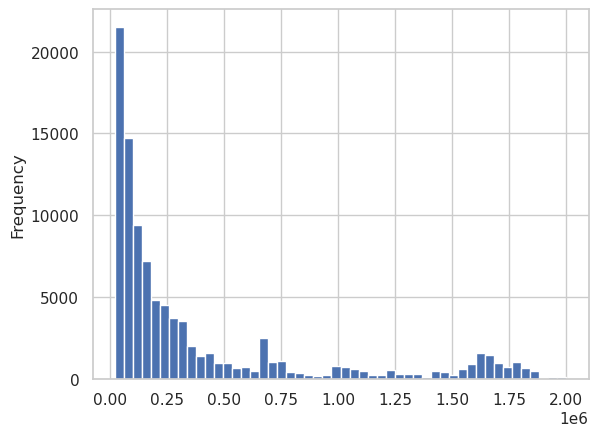

In [15]:
dist.plot(kind='hist', bins=50)

## Overview of SGLs Across Each Disease

### Count the number of sgls per GWAS Study

I would expect that, in general, that studies with more snps will have more SGLs.

In [16]:
grps = all_df.groupby(['causaldb_fn', 'mesh_term', 'author'])
counts = grps['chrA_loop'].count().to_frame()
counts.columns = ['num_sgls']

In [17]:
counts.sort_values(['mesh_term', 'num_sgls'], ascending=[True, False])

,,,num_sgls
causaldb_fn,mesh_term,author,
PH378,"Arthritis, Rheumatoid",Okada Y,9517
AT452,"Arthritis, Rheumatoid",Roslin Institute,4183
CA104,"Arthritis, Rheumatoid",Eyre S,2720
AT551,"Arthritis, Rheumatoid",Roslin Institute,2675
CA391,"Arthritis, Rheumatoid",Stahl EA,625
BE151,"Arthritis, Rheumatoid",Nealelab,439
AT454,"Arthritis, Rheumatoid",Roslin Institute,263
GD09159,"Dermatitis, Atopic",Sliz E,8463
AT280,"Diabetes Mellitus, Type 1",Roslin Institute,17964


In [18]:
counts.describe()

,num_sgls
count,18.000000
mean,5450.888889
std,5241.430304
min,263.000000
25%,2119.250000
50%,4240.000000
75%,6972.000000
max,17964.000000


### Count and plot the number of sgls, snps and genes per mesh term

In [19]:
uniq_sgls_mesh_df = all_df.drop_duplicates(subset=['chrA_loop', 'startA_loop', 'chrB_loop', 'startB_loop', 'snp_pos', 'geneid', 'mesh_term'])
uniq_sgls_mesh_df['loop_id'] = uniq_sgls_mesh_df['chrA_loop'].astype(str) + ':' \
                            + uniq_sgls_mesh_df['startA_loop'].astype(str) + '--' \
                            + uniq_sgls_mesh_df['chrB_loop'].astype(str) + ':' \
                            + uniq_sgls_mesh_df['startB_loop'].astype(str)

mesh_sgl_grps = uniq_sgls_mesh_df.groupby(['mesh_term'])
sgl_counts = mesh_sgl_grps['loop_id'].count().to_frame()
sgl_counts.columns = ['num_sgls']
sgl_counts.sort_values('num_sgls', ascending=False)

/mnt/BioHome/jreyna/tmp/ipykernel_3079904/4268753814.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uniq_sgls_mesh_df['loop_id'] = uniq_sgls_mesh_df['chrA_loop'].astype(str) + ':' \


,num_sgls
mesh_term,
"Diabetes Mellitus, Type 1",10772
"Arthritis, Rheumatoid",3859
"Dermatitis, Atopic",2037
Psoriasis,1810


In [20]:
# number of unique genes per mesh term
mesh_gene_grps = uniq_sgls_mesh_df.drop_duplicates(['geneid', 'mesh_term']).groupby(['mesh_term'])
gene_counts = mesh_gene_grps['loop_id'].count().to_frame()
gene_counts.columns = ['num_genes']
gene_counts.sort_values('num_genes', ascending=False)

,num_genes
mesh_term,
"Diabetes Mellitus, Type 1",1265
Psoriasis,546
"Arthritis, Rheumatoid",508
"Dermatitis, Atopic",346


In [21]:
# number of unique snps per mesh term
mesh_snp_grps = uniq_sgls_mesh_df.drop_duplicates(['snp_pos', 'mesh_term']).groupby(['mesh_term'])
snp_counts = mesh_snp_grps['loop_id'].count().to_frame()
snp_counts.columns = ['num_snps']
snp_counts.sort_values('num_snps', ascending=False)

,num_snps
mesh_term,
"Diabetes Mellitus, Type 1",2179
"Arthritis, Rheumatoid",457
"Dermatitis, Atopic",392
Psoriasis,254


In [22]:
combine_uniq_mesh_counts = pd.concat([num_snps_study_mesh[['num_snps']], snp_counts, sgl_counts, gene_counts], axis=1)
combine_uniq_mesh_counts.columns = ['num_total_snps', 'num_snps', 'num_sgls', 'num_genes']
combine_uniq_mesh_counts

,num_total_snps,num_snps,num_sgls,num_genes
mesh_term,,,,
"Arthritis, Rheumatoid",1121,457,3859,508
"Dermatitis, Atopic",674,392,2037,346
"Diabetes Mellitus, Type 1",7729,2179,10772,1265
Psoriasis,590,254,1810,546


In [23]:
num_snps_study_mesh

,num_snps,filename,author
mesh_term,,,
"Arthritis, Rheumatoid",1121,AT452AT454AT551BE151CA104CA391PH378,Roslin InstituteRoslin InstituteRoslin Institu...
"Dermatitis, Atopic",674,GD09159,Sliz E
"Diabetes Mellitus, Type 1",7729,AT280CA265CA266GD08996GD09063GD09519GD09657,Roslin InstituteOnengut Gumuscu SOnengut Gumus...
Psoriasis,590,AT258AT548GD09415,Roslin InstituteRoslin InstituteTsoi LC


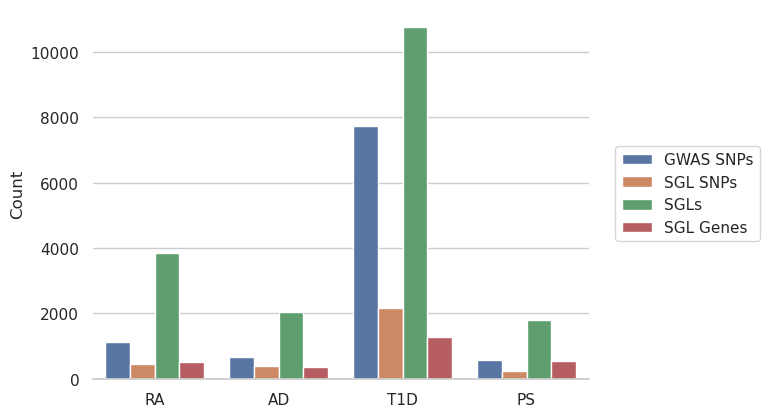

In [25]:
# extract data
plot_data = combine_uniq_mesh_counts.melt(ignore_index=False).reset_index()
plot_data.replace({'num_total_snps': 'GWAS SNPs', 'num_snps': 'SGL SNPs',
                    'num_genes': 'SGL Genes', 'num_sgls': 'SGLs',
                    'Arthritis, Rheumatoid': 'RA', 'Dermatitis, Atopic': 'AD',
                    'Diabetes Mellitus, Type 1': 'T1D', 'Psoriasis': 'PS'}, inplace=True)

# plot data
fig, ax = plt.subplots()

sns.barplot(plot_data, x='mesh_term', y='value', hue='variable', ax=ax)

# remove left spine
sns.despine(left=True)

# move legend
sns.move_legend(ax, "upper center", bbox_to_anchor=(1.2, 0.65))

# rotate X-Axis Ticks by 45-degrees
#ax.tick_params(axis='x', labelrotation = 75)

# set labels
ax.set_xlabel('')
ax.set_ylabel('Count')
legend = ax.legend_
legend.set_title('') 

outfn = os.path.join(outdir, 'sgl_breakdowns.png')
fig.savefig(outfn, dpi=600, bbox_inches='tight')

We can see that Type 1 Diabetes has the most number of SGLs. 

In [26]:
mesh_grps = all_df.groupby(['mesh_term'])

In [27]:
def get_top_counts(df, n=10):
    sorted_df = df.genename.value_counts().iloc[0:n]
    return(sorted_df)
mesh_grps.apply(get_top_counts)

mesh_term                  genename  
Arthritis, Rheumatoid      IER3-AS1       391
                           FLOT1          391
                           IER3           391
                           ARID5B         326
                           HIST1H2AG      287
                           HIST1H2BJ      287
                           HIST1H2BE      277
                           AL353759.1     277
                           Z84485.1       257
                           BRPF3          257
Dermatitis, Atopic         TRIB1          335
                           NFKBIA         301
                           MIR6090        275
                           ZBTB10         237
                           AC009812.1     237
                           ESYT1          173
                           AC034102.7     173
                           RPL41          173
                           ZC3H10         173
                           ARFRP1         142
Diabetes Mellitus, Type 1  AC138894.1    1

If we get the top SGLs based on genes we can see that gene such as NFKBIA are coming up.

In [28]:
cols = ['chrA_loop', 'startA_loop', 'endA_loop',
         'chrB_loop', 'startB_loop', 'endB_loop',
         '-log10_qval_loop', 'sample',
         'end_snp', 'snp_anchor', 
         'genename', 'geneid', 
         'mesh_term', 'author', 'causaldb_fn']

new_cols = ['ChrA', 'StartA', 'EndA',
             'ChrB', 'StartB', 'EndB',
             '-log10(Q values)', 'Sample Name',
             'SNP Pos', 'SNP Anchor', 
             'Gene Name', 'Gene ID', 
             'Mesh Term', 'Author', 'CAUSALdb Study ID']

# mesh_outfn = os.path.join(outdir, 'sgls.supplemental_table.xlsx')
# with pd.ExcelWriter(mesh_outfn) as fw:
#     for grp, grp_df in mesh_grps:
#         tdf = grp_df[cols].sort_values(['author', 'sample', 'chrA_loop', 'startA_loop', 'chrB_loop', 'startB_loop', 'end_snp', 'geneid'])
#         tdf.loc[:, 'chrA_loop'] = 'chr' + tdf.loc[:, 'chrA_loop'].astype(str)
#         tdf.loc[:, 'chrB_loop'] = 'chr' + tdf.loc[:, 'chrB_loop'].astype(str)
#         tdf.columns = new_cols
#         tdf.to_excel(fw, sheet_name=grp[0], index=False)

## Diving into SGLs for T1D

In [29]:
t1d_df = mesh_grps.get_group('Diabetes Mellitus, Type 1')

In [30]:
t1d_df.geneid.nunique()

1265

In [31]:
sgl_viz_cols = ['chrom', 'end_snp',
                'genename', 'geneid', 'start_gene', 'end_gene',
                'startA_loop', 'startB_loop', '-log10_qval_loop',
                'sample', 'author']
t1d_df.sort_values(['-log10_qval_loop', 'chrom', 'end_snp'], ascending=[False, True, True])[sgl_viz_cols].head(10)

,chrom,end_snp,genename,geneid,start_gene,end_gene,startA_loop,startB_loop,-log10_qval_loop,sample,author
27791,13,91310826,MIR17HG,ENSG00000215417,91347819,91347820,91310000,91345000,625.319750,m_loops,Forgetta V
27792,13,91312880,MIR17HG,ENSG00000215417,91347819,91347820,91310000,91345000,625.319750,m_loops,Forgetta V
24057,13,91310826,MIR17HG,ENSG00000215417,91347819,91347820,91310000,91345000,538.991056,m_loops,Forgetta V
24058,13,91312880,MIR17HG,ENSG00000215417,91347819,91347820,91310000,91345000,538.991056,m_loops,Forgetta V
24748,13,91310826,MIR17HG,ENSG00000215417,91347819,91347820,91310000,91345000,432.843386,m_loops,Forgetta V
24749,13,91312880,MIR17HG,ENSG00000215417,91347819,91347820,91310000,91345000,432.843386,m_loops,Forgetta V
24296,13,91310826,MIR17HG,ENSG00000215417,91347819,91347820,91310000,91345000,401.119394,m_loops,Forgetta V
24297,13,91312880,MIR17HG,ENSG00000215417,91347819,91347820,91310000,91345000,401.119394,m_loops,Forgetta V
24434,13,91310826,MIR17HG,ENSG00000215417,91347819,91347820,91310000,91345000,388.777188,m_loops,Forgetta V
24435,13,91312880,MIR17HG,ENSG00000215417,91347819,91347820,91310000,91345000,388.777188,m_loops,Forgetta V


In [32]:
t1d_uniq_sgls = t1d_df.drop_duplicates(['chrA_loop', 'chrB_loop', 'startA_loop', 'startB_loop', 'geneid', 'start_snp'])

### Count and plot the number of sgls and snps per gene

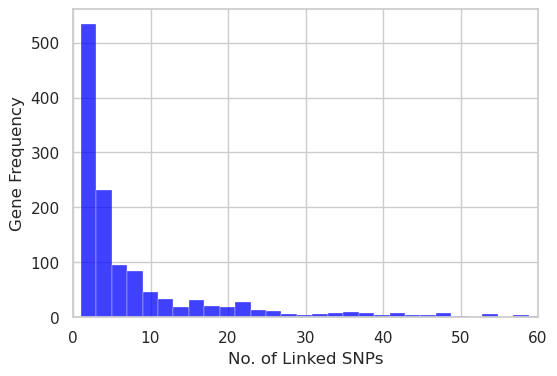

In [33]:
# getting the data
snps_per_gene = t1d_uniq_sgls.groupby('geneid').snp_pos.nunique().sort_values(ascending=False).reset_index()

# plotting
fig, ax = plt.subplots(figsize=(6,4))
sns.set_theme(style="whitegrid")
sns.histplot(snps_per_gene['snp_pos'], color='blue', binwidth=2, ax=ax, element='bars')

ax.set_xlim(0, 60)
ax.set_xlabel('No. of Linked SNPs')
ax.set_ylabel('Gene Frequency')
ax.set_title('')

outfn = os.path.join(outdir, 't1d_sgls.snps_per_gene.png')
fig.savefig(outfn, dpi=600, bbox_inches='tight')


In [34]:
snps_per_gene.snp_pos.describe()

count    1265.000000
mean        8.515415
std        14.561903
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       268.000000
Name: snp_pos, dtype: float64

In [35]:
((snps_per_gene.snp_pos.value_counts() / len(snps_per_gene)) * 100).head(10)

snp_pos
1     28.379447
2     13.833992
4      9.249012
3      9.011858
6      4.426877
7      4.031621
5      3.162055
8      2.687747
9      2.213439
15     1.422925
Name: count, dtype: float64

In [36]:
# tdf = snps_per_gene.snp_pos.sort_values(ascending=True).to_frame()
# tdf['pos'] = list(range(tdf.shape[0]))
# tdf.columns = ['num_linked_snps', 'pos']

# # plotting
# fig, ax = plt.subplots(figsize=(6,4))
# sns.set_theme(style="whitegrid")
# sns.scatterplot(tdf, x='pos', y='num_linked_snps', s=10)

# #ax.set_xlim(0, 60)
# ax.set_xlabel('Gene')
# ax.set_ylabel('No. of Linked SNPs')
# ax.set_title('')
# #ax.set_xticklabels([])
# # outfn = os.path.join(outdir, 't1d_sgls.snps_per_gene.png')
# # fig.savefig(outfn, dpi=600, bbox_inches='tight')


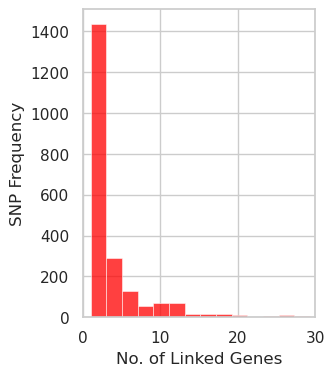

In [37]:
# getting the data
genes_per_snp = t1d_uniq_sgls.groupby('snp_pos').geneid.nunique().sort_values(ascending=False).reset_index()

# plotting
fig, ax = plt.subplots(figsize=(3,4))
sns.set_theme(style="whitegrid")
sns.histplot(genes_per_snp['geneid'], color='red', binwidth=2, ax=ax)

ax.set_xlim(0, 30)
ax.set_xlabel('No. of Linked Genes')
ax.set_ylabel('SNP Frequency')

outfn = os.path.join(outdir, 't1d_sgls.genes_per_snp.png')
fig.savefig(outfn, dpi=600, bbox_inches='tight')

In [38]:
genes_per_snp.geneid.describe()

count    2179.000000
mean        4.943552
std         8.647575
min         1.000000
25%         1.000000
50%         2.000000
75%         5.000000
max        86.000000
Name: geneid, dtype: float64

In [39]:
((genes_per_snp.geneid.value_counts() / len(genes_per_snp)) * 100).head(10)

geneid
1     30.885727
2     23.267554
3     11.748508
4      6.792106
5      6.424966
7      3.166590
10     2.707664
6      2.707664
12     2.524094
8      1.560349
Name: count, dtype: float64

### Compare to the Consensus Gene List

In [40]:
def print_genelist(genelist):
    print('\n'.join(list(genelist)))

#### Save a list of unique genes for T1D

In [41]:
# get the uniq T1D SGL genes
uniq_genes = t1d_df.genename.unique()
print('The unique number of genes is: {}'.format(len(uniq_genes)))

The unique number of genes is: 1258


In [42]:
# save the SGL genes found for T1D
uniq_fn = os.path.join(outdir, 'uniq_genes.t1d.txt')
with open(uniq_fn, 'w') as fw:
    s = '\n'.join(sorted(uniq_genes))
    fw.write(s)

#### Load the consensus T1D gene list

In [43]:
t1d_consensus_list_fn = '<path-to-consensus-gene-list>' # example consensus_gene_list.txt
t1d_consensus_genes = pd.read_table(t1d_consensus_list_fn, header=None, names=['genename'])
print('The number of consensus genes is: {}'.format(t1d_consensus_genes.shape[0]))

The number of consensus genes is: 497


In [44]:
'IL15' in t1d_consensus_genes.genename.tolist()

True

In [45]:
t1d_consensus_genes

,genename
0,APOB
1,PI4KA
2,PSMB8
3,AMBP
4,CD6
...,...
492,KLF3-AS1
493,CTRB2
494,CLN3
495,IL6R


#### Overlap the SGL genes with the consensus genes 

In [46]:
t1d_plus_consensus_df = t1d_df.loc[t1d_df.genename.isin(t1d_consensus_genes.iloc[:, 0].tolist())]

In [47]:
shared_t1d_plus_consensus_genes = sorted(t1d_plus_consensus_df.genename.unique().tolist())
print('The unique number of shared genes is: {}'.format(len(shared_t1d_plus_consensus_genes)))

The unique number of shared genes is: 95


In [48]:
all_t1d_genes = set(t1d_df.genename.tolist())

In [49]:
only_t1d_genes = all_t1d_genes.difference(shared_t1d_plus_consensus_genes)

In [50]:
# save the SGL genes found for T1D
uniq_fn = os.path.join(outdir, 'left_venn_only.uniq_genes.t1d.txt')
with open(uniq_fn, 'w') as fw:
    s = '\n'.join(sorted(only_t1d_genes))
    fw.write(s)

## Investigating Shared Genes

In [51]:
# extract protein coding genes and non-MT
prot_list = ['protein_coding', 'IG_V_gene', 'IG_C_gene', 'IG_J_gene',
             'TR_C_gene', 'TR_J_gene', 'TR_V_gene', 'TR_D_gene', 'IG_D_gene']
base_genes_df = gencode_df.loc[(gencode_df.genetype.isin(prot_list)) & (~gencode_df.chrom.isin(['chrM']))]

# get shared genes for T1D
shared_gene_df = base_genes_df.loc[base_genes_df.genename.isin(shared_t1d_plus_consensus_genes)]

# set associated sgls
shared_gene_sgls = t1d_df.loc[all_df.geneid.isin(shared_gene_df.geneid.tolist())]

# testing the removal of hist proteins
shared_gene_sgls = shared_gene_sgls.loc[~shared_gene_sgls.genename.str.contains('HIST')]

# add distance 
shared_gene_sgls.loc[:, 'distance'] = shared_gene_sgls.loc[:, 'startB_loop'] - shared_gene_sgls.loc[:, 'startA_loop']

In [52]:
shared_gene_sgls

,chrA_loop,startA_loop,endA_loop,chrB_loop,startB_loop,endB_loop,-log10_qval_loop,chrom,start_snp,end_snp,...,end_gene,genename,geneid,strand,sample,mesh_term,author,filename,snp_pos,distance
0,12,111405000,111410000,12,111445000,111450000,8.718607,12,111446803,111446804,...,111405948,SH2B3,ENSG00000111252,+,m_loops,"Diabetes Mellitus, Type 1",Onengut Gumuscu S,CA266,12:111446804,40000
1,16,28490000,28495000,16,28535000,28540000,16.419632,16,28494338,28494339,...,28539174,NUPR1,ENSG00000176046,-,m_loops,"Diabetes Mellitus, Type 1",Onengut Gumuscu S,CA266,16:28494339,45000
6,10,6050000,6055000,10,6085000,6090000,36.969800,10,6054703,6054704,...,6089034,RBM17,ENSG00000134453,+,m_loops,"Diabetes Mellitus, Type 1",Onengut Gumuscu S,CA266,10:6054704,35000
7,10,6050000,6055000,10,6085000,6090000,36.969800,10,6052733,6052734,...,6089034,RBM17,ENSG00000134453,+,m_loops,"Diabetes Mellitus, Type 1",Onengut Gumuscu S,CA266,10:6052734,35000
20,12,55995000,56000000,12,56040000,56045000,9.503044,12,56041627,56041628,...,55997180,SUOX,ENSG00000139531,+,m_loops,"Diabetes Mellitus, Type 1",Onengut Gumuscu S,CA266,12:56041628,45000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98107,3,46295000,46300000,3,46405000,46410000,5.597431,3,46299138,46299139,...,46407166,CCRL2,ENSG00000121797,+,m_loops,"Diabetes Mellitus, Type 1",Onengut Gumuscu S,CA265,3:46299139,110000
98109,3,46295000,46300000,3,46405000,46410000,5.597431,3,46298793,46298794,...,46407166,CCRL2,ENSG00000121797,+,m_loops,"Diabetes Mellitus, Type 1",Onengut Gumuscu S,CA265,3:46298794,110000
98111,3,46295000,46300000,3,46405000,46410000,5.597431,3,46297693,46297694,...,46407166,CCRL2,ENSG00000121797,+,m_loops,"Diabetes Mellitus, Type 1",Onengut Gumuscu S,CA265,3:46297694,110000
98113,3,46405000,46410000,3,46440000,46445000,10.450805,3,46440557,46440558,...,46407166,CCRL2,ENSG00000121797,+,m_loops,"Diabetes Mellitus, Type 1",Onengut Gumuscu S,CA265,3:46440558,35000


In [53]:
# calculating genes which are present in SGLs across more than 3 samples
shared_gene_freqs = shared_gene_sgls.drop_duplicates(['genename', 'sample']).genename.value_counts()
shared_genes_high_freq = shared_gene_freqs[shared_gene_freqs > 3]
shared_genes_high_freq_list = shared_genes_high_freq.index.tolist()

In [54]:
pd.options.display.max_rows = 1000
pd.options.display.max_colwidth = 1000
pd.options.display.max_columns = 100

check_genes = []
candidates = shared_gene_sgls.loc[shared_gene_sgls.distance > 200000].sort_values(['distance', 'genename'], ascending=[False, True])
candidates = candidates.loc[candidates.chr_gene != 6]
candidates = candidates.loc[~candidates.genename.isin(check_genes)]
candidates = candidates.loc[candidates.genename.isin(shared_genes_high_freq_list)]
candidates = candidates.loc[~candidates['sample'].str.startswith('THP-1')]

# display(candidates.iloc[:, 14:])
# #pd.options.display.max_rows = 200


In [55]:
candidates.genename.unique()

array([], dtype=object)

## Investigate Novel Genes

In [56]:
# extract protein coding genes and non-MT
prot_list = ['protein_coding', 'IG_V_gene', 'IG_C_gene', 'IG_J_gene',
             'TR_C_gene', 'TR_J_gene', 'TR_V_gene', 'TR_D_gene', 'IG_D_gene']
base_genes_df = gencode_df.loc[(gencode_df.genetype.isin(prot_list)) & (~gencode_df.chrom.isin(['chrM']))]

# get novel genes for T1D
novel_gene_df = base_genes_df.loc[base_genes_df.genename.isin(only_t1d_genes)]

# set associated sgls
novel_gene_sgls = t1d_df.loc[all_df.geneid.isin(novel_gene_df.geneid.tolist())]

# testing the removal of hist proteins
novel_gene_sgls = novel_gene_sgls.loc[~novel_gene_sgls.genename.str.contains('HIST')]

# add distance 
novel_gene_sgls.loc[:, 'distance'] = novel_gene_sgls.loc[:, 'startB_loop'] - novel_gene_sgls.loc[:, 'startA_loop']

In [57]:
#print(','.join(list(novel_gene_sgls.geneid.unique())))

In [58]:
# counting snp-gene pairs 
novel_gene_sgls.loc[:, 'sgname'] = novel_gene_sgls.loc[:, 'genename'] + ' & ' + novel_gene_sgls.loc[:, 'snp_pos']
sgpair_counts = novel_gene_sgls.sgname.value_counts().to_frame()

I'm interested in the frequency of each SNP + gene pair. Hopefully there is a pair with lots of samples. 

In [59]:
sgl_freqs = sgpair_counts.sort_index()['count'].unique()
sgl_freqs

array([  2,  15,   5,   1,   8,   4,   3,   6,  12,   9,  18,  45,  19,
        10,  30,  75,  16,  25,  20,  36,  22,  24,  11,  38, 152,  23,
        28,  35,   7,  17,  13,  14,  50,  40,  49,  21,  54, 115,  46,
        26,  66,  42,  85,  27,  51,  32,  90,  65,  39,  33, 108,  99,
        76, 228, 138,  60, 117,  29])

In [60]:
pd.options.display.max_rows = 100
display(sgpair_counts)
pd.options.display.max_rows = 100

,count
sgname,
SGF29 & 16:28494339,228
AC138894.1 & 16:28554837,152
APOBR & 16:28554346,152
APOBR & 16:28554837,152
AC138894.1 & 16:28554346,152
...,...
STARD3 & 17:39813896,1
CEP76 & 18:12774895,1
OSM & 22:30097893,1


In [61]:
# calculating genes which are present in SGLs across more than 3 samples
novel_gene_freqs = novel_gene_sgls.drop_duplicates(['genename', 'sample']).genename.value_counts()
novel_genes_high_freq = novel_gene_freqs[novel_gene_freqs > 3]
novel_genes_high_freq_list = novel_genes_high_freq.index.tolist()

In [62]:
pd.options.display.max_rows = 1000
pd.options.display.max_colwidth = 1000
pd.options.display.max_columns = 100

check_genes = ['CD63', 'AC009779.2', 'AC073896.2', 'AC145285.3', 'SETD9', 'PUM3', 'AC022506.1', 'DDIT3', 'MBD6', 'PKNOX1', 'GPBP1']
check_genes += ['SLC30A1', 'ZBTB37', 'EIF1', 'CENPL', 'DARS2', 'ZFYVE26', 'KMT2E', 'NIPBL', 'BRIX1', 'RAD1', 'LONRF1']
check_genes += ['RAPGEF6', 'ITGB1', 'FAM210A', 'RNMT', 'DTL', 'INTS7', 'SIMM12', 'EPC1', 'SMIM12', 'NUDT6']
check_genes += ['RFX3', 'SPATA5', 'DUSP28', 'HSPA4', 'ZIC2', 'ANKMY1', 'RNPEPL1', 'ZSCAN22', 'FKBP1B']
check_genes += ['WDCP', 'SFPQ', 'CYP20A1', 'DOCK9', 'NCK1', 'FANCI', 'RRP1', 'STK40', 'AFG3L2']
check_genes += ['STAG1', 'NEK7', 'UBE2G2', 'RO60', 'DNAJC27', 'TNFSF4', 'ABHD2', 'IFT27', 'GDF9', 'UQCRQ']
check_genes += ['PRKAR1A', 'WIPI1', 'NCF4', 'TRAPPC10', 'PTRHD1', 'HAPLN3', 'HEXIM2', 'KIF14', 'UBAC2']
check_genes += ['GDF11', 'STARD3', 'SECISBP2', 'RARA', 'CCR1', 'CCR2', 'ORMDL2', 'SENP3', 'SENP3-EIF4A1']
candidates = novel_gene_sgls.loc[novel_gene_sgls.distance > 200000].sort_values(['distance', 'genename'], ascending=[False, True])
candidates = candidates.loc[candidates.chr_gene != 6]
candidates = candidates.loc[~candidates.genename.isin(check_genes)]
candidates = candidates.loc[candidates.genename.isin(novel_genes_high_freq_list)]
candidates = candidates.loc[~candidates['sample'].str.startswith('THP-1')]

#display(candidates.iloc[:, 14:])
#pd.options.display.max_rows = 200


In [63]:
for x in candidates.genename.unique():
    print(x)
    break

In [64]:
nck1 = candidates.loc[candidates.genename == 'NCK1']
nck1

,chrA_loop,startA_loop,endA_loop,chrB_loop,startB_loop,endB_loop,-log10_qval_loop,chrom,start_snp,end_snp,rsid,maf,ea,nea,beta,se,p,zscore,paintor,caviarbf,finemap,meta_id,block_id,label,causaldb_fn,snp_anchor,chr_gene,start_gene,end_gene,genename,geneid,strand,sample,mesh_term,author,filename,snp_pos,distance,sgname


Unfortunately there are not. Initially I was trying to find an example where a SGL is found across many samples but this is just not found in the data. So I started to think, what else can I find or what other point can I make? For now, the point that I will try making is that we found a good SNP (or gene) which is found across many samples. 

I'll start with a good SNP, if I find one. 

In [65]:
# snp_counts = novel_gene_sgls.drop_duplicates(subset=['sample', 'snp_pos']) # want unique sample + snps
# snp_counts = snp_counts.groupby(by=['snp_pos']).count()['chrA_loop'] # counting the unique number of snps per sample 
# snp_counts = snp_counts.reset_index().rename(columns={'chrA_loop': 'count'}).sort_values(['count'], ascending=[True, False]) # cleaning + sorting
# snp_counts = snp_counts.pivot(index='snp_pos', columns='sample_grp', values='count', ) # pivoting for side-by-side analysis of grps
# snp_counts = snp_counts.fillna(0) # remove NaN's
# snp_counts = snp_counts.astype(int) # convert to ints
# snp_counts.loc[:, 'sum'] = snp_counts.iloc[:, 0:6].sum(axis=1) # add row sum
# snp_counts.loc[:, 'max'] = snp_counts.iloc[:, 0:6].max(axis=1) # add row max

# # add the mb location
# def get_mb(x):
#     spl = x.split(':')
#     res = spl[0] + ':' + spl[1][0:2]
#     return(res)
# snp_counts['chr_mb'] = [get_mb(x)for x in snp_counts.index.values]

# # filter based on the max
# snp_counts_flt = snp_counts.loc[snp_counts['max'] > 2].sort_values(['chr_mb', 'max'], ascending=[True, False])

# snp_counts_flt = snp_counts_flt.reset_index().set_index(['chr_mb', 'snp_pos']) # creating multi-index with chr_mb

In [66]:

# # highlight based on the max
# def highlight_max(data, color='yellow'):
#     '''
#     highlight the maximum in a Series or DataFrame
#     '''
#     attr = 'background-color: {}'.format(color)
#     if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
#         is_gte_thresh = data > 3
#         return [attr if v else '' for v in is_gte_thresh]
#     else:  # from .apply(axis=None)
#         is_gte_thresh = data > 3
#         return pd.DataFrame(np.where(is_max, attr, ''),
#                             index=data.index, columns=data.columns)

# snp_counts_flt.style.apply(highlight_max, subset=['max'])

In [67]:
novel_gene_sgls.loc[(novel_gene_sgls.snp_pos.str.contains('^11:64'))]['genename']

38244        FERMT3
38245        FERMT3
38246        FERMT3
38247        FERMT3
38348       TRMT112
38349         PRDX5
38350       TRMT112
38351         PRDX5
38352       TRMT112
38353         PRDX5
38532         FKBP2
38533    AP001453.5
38534         FKBP2
38535    AP001453.5
38536         FKBP2
38537    AP001453.5
38538         FKBP2
38539    AP001453.5
38711       RASGRP2
38712       RASGRP2
38713       RASGRP2
38714       RASGRP2
38911         FKBP2
38912    AP001453.5
38913         FKBP2
38914    AP001453.5
38915         FKBP2
38916    AP001453.5
38917         FKBP2
38918    AP001453.5
39223        FERMT3
39224        FERMT3
39225        FERMT3
39226        FERMT3
39227        FERMT3
39228         FKBP2
39229    AP001453.5
39230         FKBP2
39231    AP001453.5
39232         FKBP2
39233    AP001453.5
39792        FERMT3
39793        FERMT3
39794        FERMT3
39797         OTUB1
39798         OTUB1
39799         OTUB1
39800         OTUB1
39801         STIP1
39802         STIP1


#### Perform Mann-Whitney Test Between GWAS Catalog & SGL Distributions

In [68]:
# preprocess the GWAS data first
pd.set_option('display.max_columns', None)

# loading GWAS Catalog data
gc_data = pd.read_table('results/hg38/external_studies/gwas_catalog/gwas_catalog_v1.0-associations_e112_r2024-07-27.tsv')

# extract genome-wide significance values
gc_data.loc[gc_data.loc[:, 'P-VALUE'] < 5*10**(-8)]

# dropping duplicate values
gc_data = gc_data.loc[gc_data.duplicated(['CHR_ID', 'CHR_POS'], keep='first')]

# drop 
gc_data = gc_data.loc[~gc_data['CHR_POS'].isna()]

# getting just the bed information
gc_data = gc_data.iloc[:, [11,12]]

# remove those that cannot be converted
def can_convert_to_int(x):
    try:
        int(x)
        return(True)
    except:
        return(False)
gc_data = gc_data.loc[gc_data['CHR_POS'].apply(can_convert_to_int)]

# convert to int
gc_data.loc[:, 'CHR_POS'] = gc_data['CHR_POS'].astype(int)


# rename and reorder
gc_data.rename(columns={'CHR_ID': 'chrom', 'CHR_POS': 'end'}, inplace=True)
gc_data['start'] = gc_data['end'] - 1
gc_data = gc_data.iloc[:, [0,2,1]]

# add chr
gc_data['chrom'] = 'chr' + gc_data['chrom']

# add 1mb to start and end
# gc_data.iloc[:, 1] = gc_data.iloc[:, 1].apply(lambda x: max(0, x - 1000000))
# gc_data.iloc[:, 2] = gc_data.iloc[:, 2] + 1000000
gc_data.iloc[:, 1] = gc_data.iloc[:, 1].apply(lambda x: max(0, x - 100000))
gc_data.iloc[:, 2] = gc_data.iloc[:, 2] + 100000

# sort
gc_data.sort_values(['chrom', 'start'], inplace=True)

/mnt/BioHome/jreyna/tmp/ipykernel_3079904/4155706276.py:5: DtypeWarning: Columns (12,13,23) have mixed types. Specify dtype option on import or set low_memory=False.
  gc_data = pd.read_table('results/hg38/external_studies/gwas_catalog/gwas_catalog_v1.0-associations_e112_r2024-07-27.tsv')


In [69]:
# intersect the SNPs with genes
gc_pbt = pbt.BedTool.from_dataframe(gc_data)
gencode_prots = gencode_df.loc[gencode_df['genetype'] == 'protein_coding']
gene_pbt = pbt.BedTool.from_dataframe(gencode_prots.iloc[:, [0,1,2,5]])

# map the genes to SNPs
gc_with_genes = gc_pbt.map(gene_pbt, c='4', o='count_distinct')
gc_with_genes_df = gc_with_genes.to_dataframe(header=None, disable_auto_names=True)
gc_with_genes_df = gc_with_genes_df.drop_duplicates(subset=[0,1,2,3])

# remove entries without a gene
gc_with_genes_df = gc_with_genes_df.loc[gc_with_genes_df.iloc[:, 3] != '.']
gc_with_genes_df.iloc[:, 3] = gc_with_genes_df.iloc[:, 3].astype(int)

<Axes: ylabel='Frequency'>

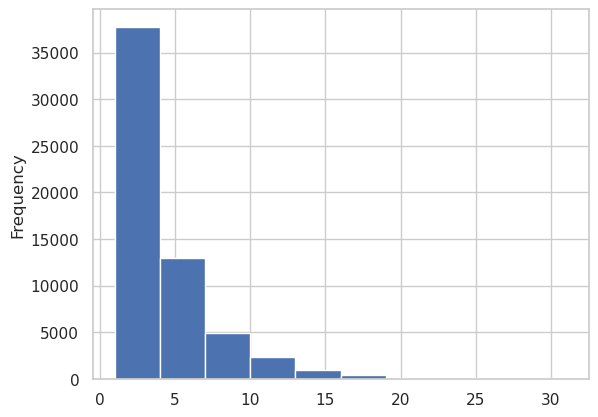

In [70]:
gc_with_genes_df.iloc[:, 3].plot(kind='hist')

In [71]:
def calculate_mannwhitenyu(dataA, dataB):

    # Step 1: Calculate medians
    median_A = np.median(data_A)
    median_B = np.median(data_B)

    # Step 2: Perform the Mann-Whitney U test
    # The test checks if the distribution of one sample is shifted relative to another
    statistic, p_value = mannwhitneyu(data_B, data_A, alternative='less')
    
    # return tuple result
    mw_ntuple = namedtuple('mw', ['median_A', 'median_B', 'statistic', 'p_value'])
    mw_result = mw_ntuple(median_A, median_B, statistic, p_value)
    return(mw_result)
    
    
def summarize_mannwhitenyu(result):

    # Print the results
    print(f"Median of A: {result.median_A}")
    print(f"Median of B: {result.median_B}")

    print(f"Mann-Whitney U statistic: {result.statistic}")
    print(f"P-value: {result.p_value}")

    # Interpretation
    alpha = 0.05  # Significance level
    if result.p_value < alpha:
        print("Reject the null hypothesis: The median of B is significantly smaller than the median of A.")
    else:
        print("Fail to reject the null hypothesis: There is no significant evidence that the median of B is smaller than the median of A.")
        
# Sample data (replace with your actual data)
data_A = np.array(gc_with_genes_df.iloc[:, 3].astype(int))  # Replace with your data for list A
data_B = np.array(genes_per_snp.geneid.astype(int))  # Replace with your data for list B

mw_genes = calculate_mannwhitenyu(data_A, data_B)
summarize_mannwhitenyu(mw_genes)

Median of A: 3.0
Median of B: 2.0
Mann-Whitney U statistic: 63911632.0
P-value: 0.07312264366314612
Fail to reject the null hypothesis: There is no significant evidence that the median of B is smaller than the median of A.


In [72]:
gc_with_genes_df

,0,1,2,3
0,chr1,860325,1060326,8
2,chr1,879471,1079472,9
3,chr1,899841,1099842,10
5,chr1,913489,1113490,10
7,chr1,923524,1123525,10
...,...,...,...,...
252858,chrX,155095892,155295893,5
252859,chrX,155233587,155433588,5
252860,chrX,155575418,155775419,2
252865,chrX,155657484,155857485,2


In [73]:
# making gc data with an id for mapping
gc_extra_data = gc_data.copy()
gc_extra_data['id'] = gc_extra_data['chrom'] + ':'  + gc_extra_data['start'].astype(str) + '-' + gc_extra_data['end'].astype(str)
gc_extra_pbt = pbt.BedTool.from_dataframe(gc_extra_data)

# map the genes to SNPs
gc_with_snps = gene_pbt.map(gc_extra_pbt, c='4', o='count_distinct')
gc_with_snps_df = gc_with_snps.to_dataframe(header=None, disable_auto_names=True)
gc_with_snps_df = gc_with_snps_df.drop_duplicates(subset=[0,1,2,3])

# remove entries without a gene
gc_with_snps_df = gc_with_snps_df.loc[gc_with_snps_df.iloc[:, 4] != '.']
gc_with_snps_df.iloc[:, 4] = gc_with_snps_df.iloc[:, 4].astype(int)


In [74]:
gc_with_snps_df

,0,1,2,3,4
3,chr1,923927,944581,ENSG00000187634,6
4,chr1,944202,959309,ENSG00000188976,8
5,chr1,960583,965719,ENSG00000187961,8
6,chr1,966496,975865,ENSG00000187583,8
7,chr1,975203,982093,ENSG00000187642,8
...,...,...,...,...,...
19913,chrX,155380786,155381134,ENSG00000277858,1
19914,chrX,155382114,155383230,ENSG00000274791,1
19917,chrX,155489010,155669944,ENSG00000185973,2
19918,chrX,155767811,155782459,ENSG00000168939,2


In [75]:
# Sample data (replace with your actual data)
data_A = np.array(gc_with_snps_df.iloc[:, 4].astype(int))  # Replace with your data for list A
data_B = np.array(snps_per_gene.snp_pos.astype(int))  # Replace with your data for list B

mw_genes = calculate_mannwhitenyu(data_A, data_B)
summarize_mannwhitenyu(mw_genes)

Median of A: 7.0
Median of B: 3.0
Mann-Whitney U statistic: 7951761.5
P-value: 1.1348591943185376e-70
Reject the null hypothesis: The median of B is significantly smaller than the median of A.
